# Wrangling

## Imports

In [51]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.svm import SVR
# from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import os


## Read In data

In [52]:
path = 'csv'

files = glob.glob(path + "/*.csv")
data_frames = []

for file in files:
    frame = pd.read_csv(file)
    frame['genre'] = frame['genre'].apply(lambda x: str(file))
    data_frames.append(frame)

    
df = pd.concat(data_frames, ignore_index=True)
df.head()


,movie_id,movie_name,year,certificate,runtime,genre,rating,description,director,director_id,star,star_id,votes,gross(in $)
0,tt9114286,Black Panther: Wakanda Forever,2022,PG-13,161 min,csv\action.csv,6.9,The people of Wakanda fight to protect their h...,Ryan Coogler,/name/nm3363032/,"Letitia Wright, \nLupita Nyong'o, \nDanai Guri...","/name/nm4004793/,/name/nm2143282/,/name/nm1775...",204835.0,NaN
1,tt1630029,Avatar: The Way of Water,2022,PG-13,192 min,csv\action.csv,7.8,Jake Sully lives with his newfound family form...,James Cameron,/name/nm0000116/,"Sam Worthington, \nZoe Saldana, \nSigourney We...","/name/nm0941777/,/name/nm0757855/,/name/nm0000...",295119.0,NaN
2,tt5884796,Plane,2023,R,107 min,csv\action.csv,6.5,A pilot finds himself caught in a war zone aft...,Jean-François Richet,/name/nm0724938/,"Gerard Butler, \nMike Colter, \nTony Goldwyn, ...","/name/nm0124930/,/name/nm1591496/,/name/nm0001...",26220.0,NaN
3,tt6710474,Everything Everywhere All at Once,2022,R,139 min,csv\action.csv,8.0,A middle-aged Chinese immigrant is swept up in...,"Dan Kwan, \nDaniel Scheinert",/name/nm3453283/,"Michelle Yeoh, \nStephanie Hsu, \nJamie Lee Cu...","/name/nm3215397/,/name/nm0000706/,/name/nm3513...",327858.0,NaN
4,tt5433140,Fast X,2023,NaN,NaN,csv\action.csv,NaN,Dom Toretto and his family are targeted by the...,Louis Leterrier,/name/nm0504642/,"Vin Diesel, \nJordana Brewster, \nTyrese Gibso...","/name/nm0004874/,/name/nm0108287/,/name/nm0879...",NaN,NaN


## Remove rows with NAN values

In [53]:
df = df.dropna().reset_index(drop=True)
df.head()

# unique_count = clean_df['genre'].nunique()
# unique_count #495 combinations in dataset

,movie_id,movie_name,year,certificate,runtime,genre,rating,description,director,director_id,star,star_id,votes,gross(in $)
0,tt1825683,Black Panther,2018,PG-13,134 min,csv\action.csv,7.3,"T'Challa, heir to the hidden but advanced king...",Ryan Coogler,/name/nm3363032/,"Chadwick Boseman, \nMichael B. Jordan, \nLupit...","/name/nm1569276/,/name/nm0430107/,/name/nm2143...",785813.0,700059566.0
1,tt0092099,Top Gun,1986,PG,109 min,csv\action.csv,6.9,As students at the United States Navy's elite ...,Tony Scott,/name/nm0001716/,"Tom Cruise, \nTim Robbins, \nKelly McGillis, \...","/name/nm0000129/,/name/nm0000209/,/name/nm0000...",461419.0,179800601.0
2,tt0499549,Avatar,2009,PG-13,162 min,csv\action.csv,7.9,A paraplegic Marine dispatched to the moon Pan...,James Cameron,/name/nm0000116/,"Sam Worthington, \nZoe Saldana, \nSigourney We...","/name/nm0941777/,/name/nm0757855/,/name/nm0000...",1322694.0,760507625.0
3,tt1392170,The Hunger Games,2012,PG-13,142 min,csv\action.csv,7.2,Katniss Everdeen voluntarily takes her younger...,Gary Ross,/name/nm0002657/,"Jennifer Lawrence, \nJosh Hutcherson, \nLiam H...","/name/nm2225369/,/name/nm1242688/,/name/nm2955...",927499.0,408010692.0
4,tt1160419,Dune,2021,PG-13,155 min,csv\action.csv,8.0,A noble family becomes embroiled in a war for ...,Denis Villeneuve,/name/nm0898288/,"Timothée Chalamet, \nRebecca Ferguson, \nZenda...","/name/nm3154303/,/name/nm0272581/,/name/nm3918...",649342.0,108327830.0


## Narrow down columns

In [54]:
df = df.loc[:, ['movie_name', 'year', 'certificate', 'runtime', 'genre', 'rating', 'votes', 'gross(in $)']]

df.head()


,movie_name,year,certificate,runtime,genre,rating,votes,gross(in $)
0,Black Panther,2018,PG-13,134 min,csv\action.csv,7.3,785813.0,700059566.0
1,Top Gun,1986,PG,109 min,csv\action.csv,6.9,461419.0,179800601.0
2,Avatar,2009,PG-13,162 min,csv\action.csv,7.9,1322694.0,760507625.0
3,The Hunger Games,2012,PG-13,142 min,csv\action.csv,7.2,927499.0,408010692.0
4,Dune,2021,PG-13,155 min,csv\action.csv,8.0,649342.0,108327830.0


## Format Columns

In [55]:
#Format runtimes into floats
def convert_runtime(string):
    return float(string.split(' ')[0])
    
df['runtime'] = df['runtime'].apply(convert_runtime)
df = df[df['runtime'] < 300]


#Format genre by using only first value
def genre_parse(genre):
    print(genre)
    genre = genre.split('\\')[-1] # remove directory path
    genre = genre[:-4]
    
    genre = genre.lower()
    print(genre)
    return genre
  
df['genre']=df['genre'].apply(genre_parse)
df = df.drop(df.loc[(df['genre'] == 'musical') | (df['genre'] == 'romance') | (df['genre'] == 'biography') | (df['genre']=='animation')].index)

# Format Certificate filter out all data points to only include movies with the G, PG, PG-13, R, and NC-17 ratings, switch Not Rated to NR
def convert_unrated(certificate):
    if certificate == 'Not Rated':
        return 'NR'
    else:
        return certificate
    
df=df.loc[(df['certificate'] == 'R') | (df['certificate'] =='PG-13') | (df['certificate'] == 'PG') | (df['certificate'] == 'Not Rated') | (df['certificate'] =='X') | (df['certificate'] == 'NC-17')]
df['certificate']=df['certificate'].apply(convert_unrated)

#Format years into ints and include only the past 25 years worth of data. 
df['year'] = df['year'].astype(int)
df = df.loc[(df['year'] >= 1997)].reset_index(drop=True)

df.head()

csv\action.csv
action
csv\action.csv
action
csv\action.csv
action
csv\action.csv
action
csv\action.csv
action
csv\action.csv
action
csv\action.csv
action
csv\action.csv
action
csv\action.csv
action
csv\action.csv
action
csv\action.csv
action
csv\action.csv
action
csv\action.csv
action
csv\action.csv
action
csv\action.csv
action
csv\action.csv
action
csv\action.csv
action
csv\action.csv
action
csv\action.csv
action
csv\action.csv
action
csv\action.csv
action
csv\action.csv
action
csv\action.csv
action
csv\action.csv
action
csv\action.csv
action
csv\action.csv
action
csv\action.csv
action
csv\action.csv
action
csv\action.csv
action
csv\action.csv
action
csv\action.csv
action
csv\action.csv
action
csv\action.csv
action
csv\action.csv
action
csv\action.csv
action
csv\action.csv
action
csv\action.csv
action
csv\action.csv
action
csv\action.csv
action
csv\action.csv
action
csv\action.csv
action
csv\action.csv
action
csv\action.csv
action
csv\action.csv
action
csv\action.csv
action
csv\action

,movie_name,year,certificate,runtime,genre,rating,votes,gross(in $)
0,Black Panther,2018,PG-13,134.0,action,7.3,785813.0,700059566.0
1,Avatar,2009,PG-13,162.0,action,7.9,1322694.0,760507625.0
2,The Hunger Games,2012,PG-13,142.0,action,7.2,927499.0,408010692.0
3,Dune,2021,PG-13,155.0,action,8.0,649342.0,108327830.0
4,The Lord of the Rings: The Fellowship of the Ring,2001,PG-13,178.0,action,8.8,1889727.0,315544750.0


# Data Engineering

## Remove Repeats and One Hot Encode

In [56]:
df_pre_eng = df
genres = df['genre'].unique()
for genre in genres:
    df[genre] = 0
names = df['movie_name'].unique()

for name in names:
    repeats = df.loc[(df['movie_name'] == name)]
    genres = []
    
    for index in list(repeats.index):
        genres.append(repeats.loc[index,'genre'])
    
    for genre in genres:
        df.loc[list(repeats.index)[0], genre] = 1
    
    df = df.drop(list(repeats.index)[1:])
    
df=df.drop(['movie_name', 'genre'], axis=1)
df.head()

,year,certificate,runtime,rating,votes,gross(in $),action,adventure,crime,family,fantasy,history,horror,mystery,scifi,sports,thriller,war
0,2018,PG-13,134.0,7.3,785813.0,700059566.0,1,1,0,0,0,0,0,0,1,0,0,0
1,2009,PG-13,162.0,7.9,1322694.0,760507625.0,1,1,0,0,1,0,0,0,1,0,0,0
2,2012,PG-13,142.0,7.2,927499.0,408010692.0,1,1,0,0,0,0,0,0,1,0,1,0
3,2021,PG-13,155.0,8.0,649342.0,108327830.0,1,1,0,0,0,0,0,0,1,0,0,0
4,2001,PG-13,178.0,8.8,1889727.0,315544750.0,1,1,0,0,1,0,0,0,0,0,0,0


In [57]:
# scale down gross earnings from dollars to millions of dollars
df['gross(in $)'] = df['gross(in $)']/1e6

# EDA

<Figure size 4000x4000 with 0 Axes>

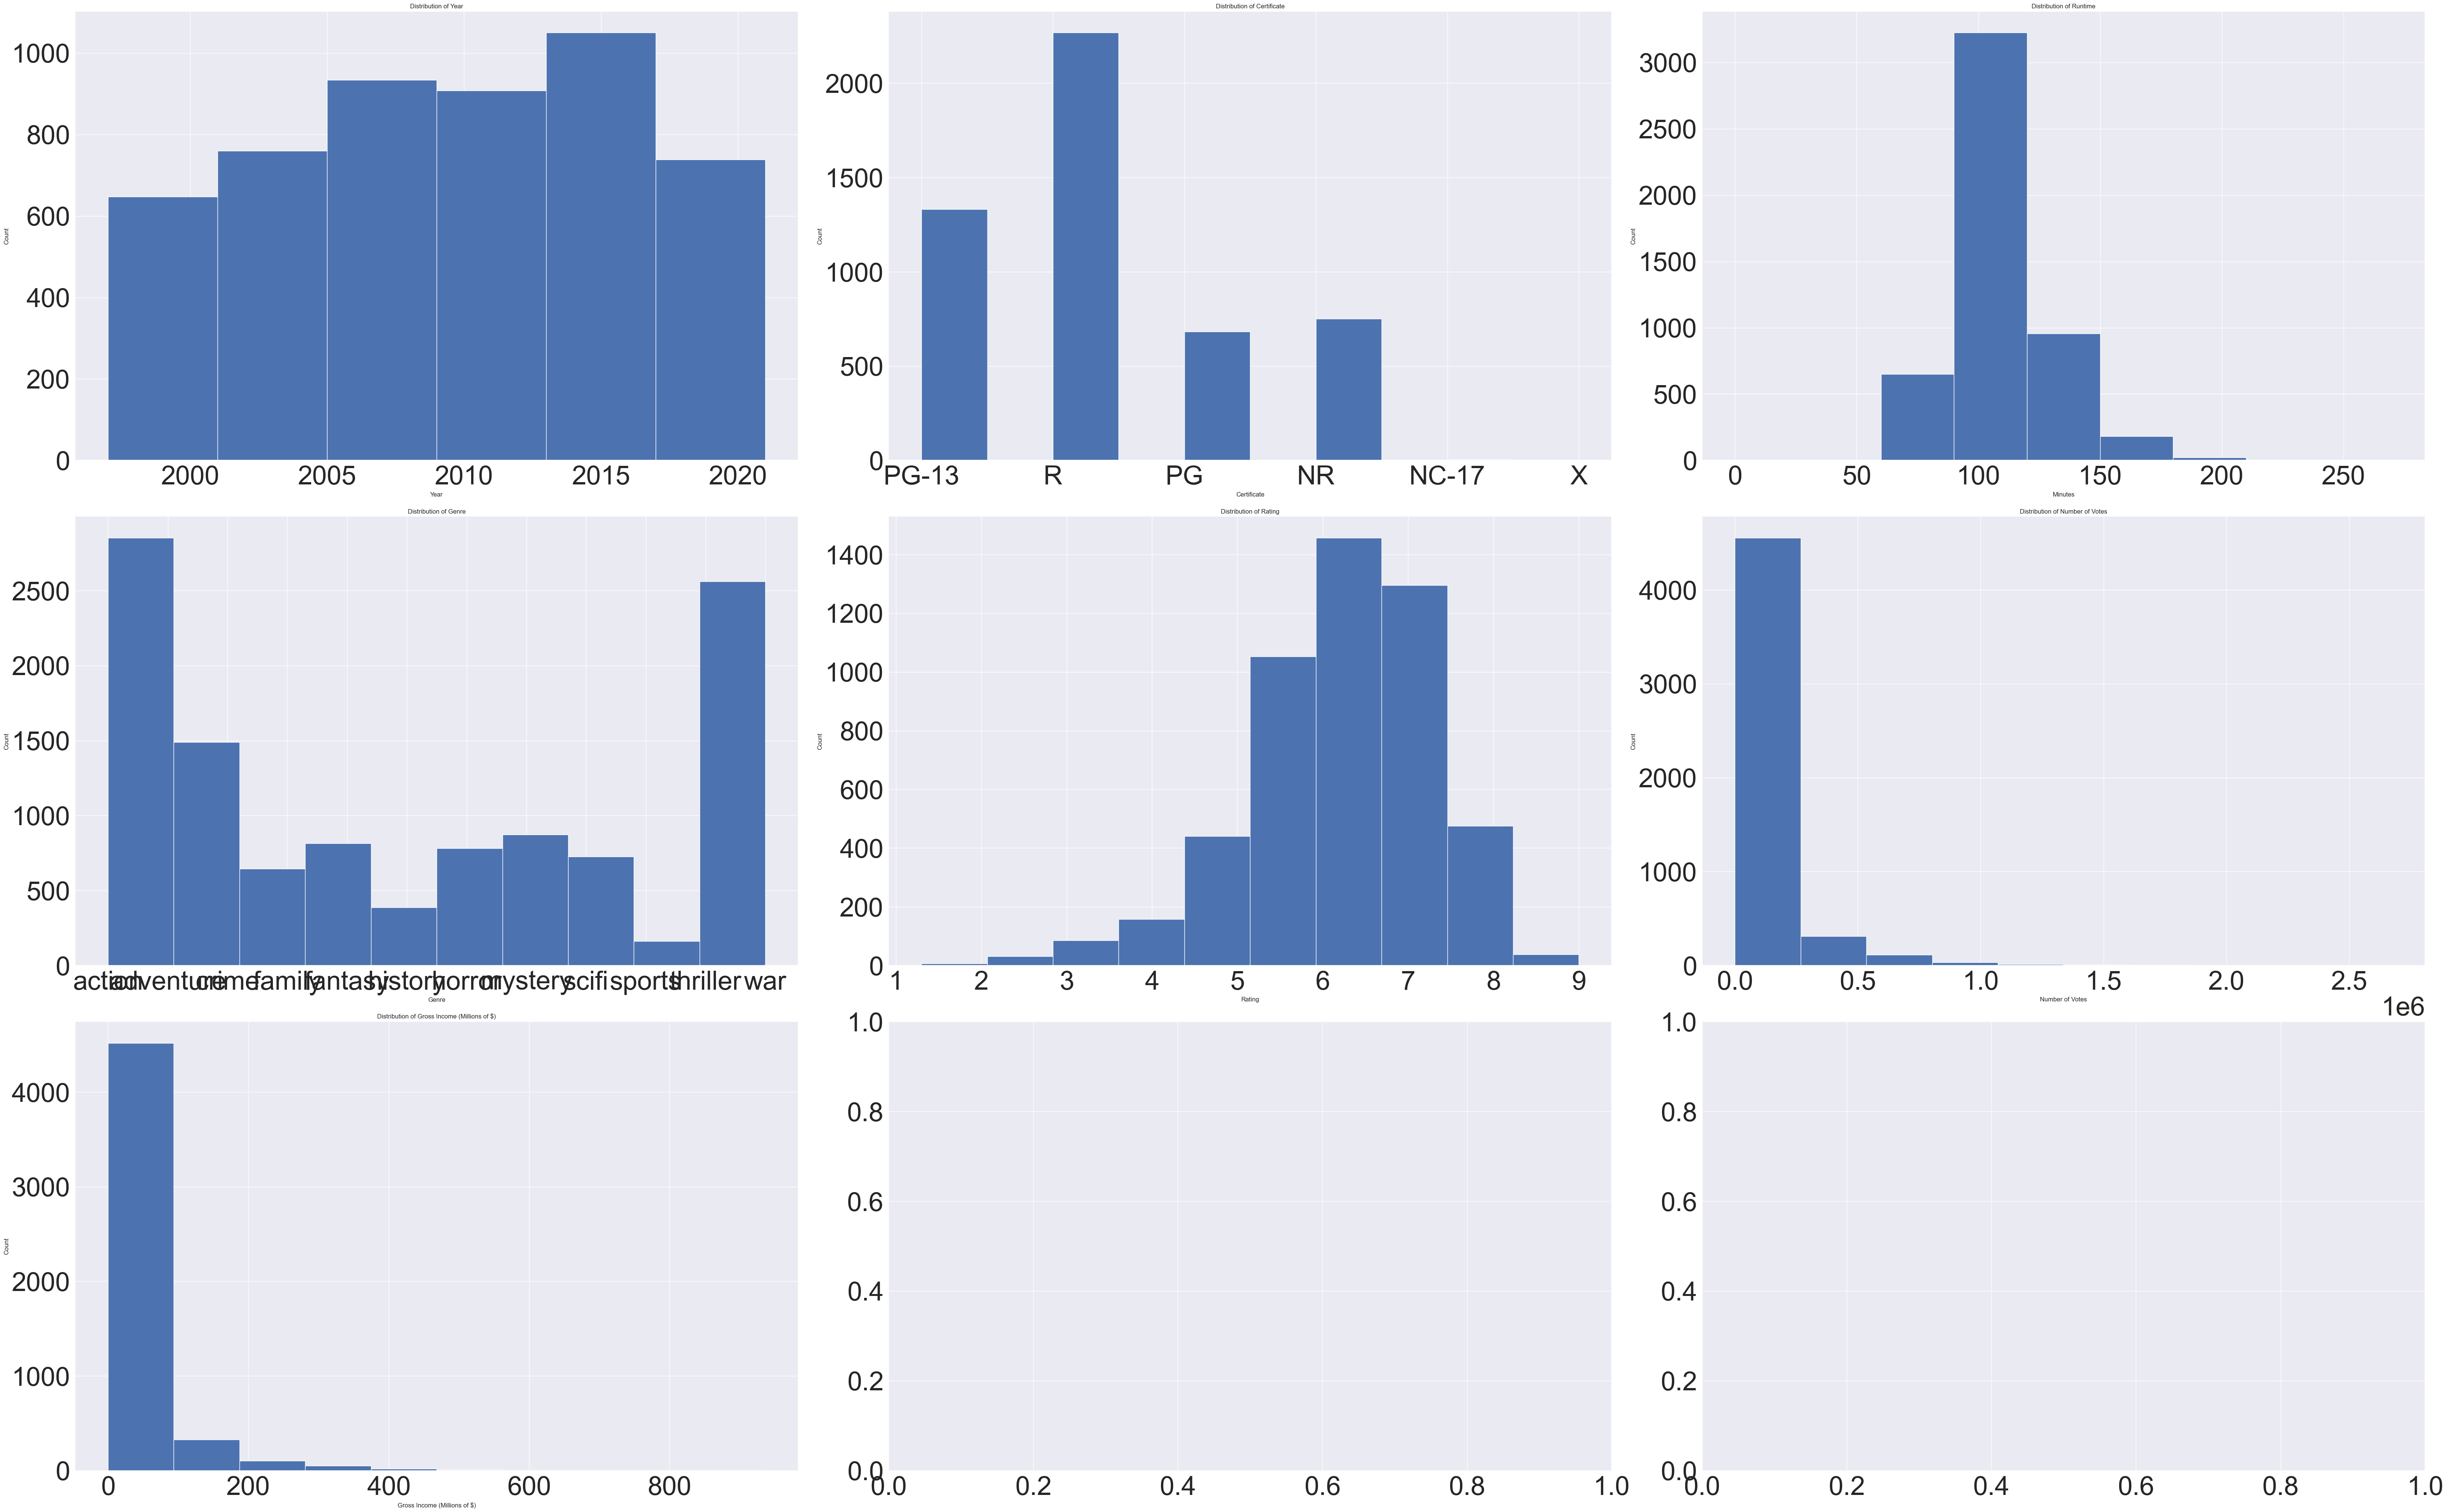

Earliest Year: 1997
Latest Year: 2022
['action' 'adventure' 'crime' 'family' 'fantasy' 'history' 'horror'
 'mystery' 'scifi' 'sports' 'thriller' 'war']
Shortest Movie Runtime: 45.0 min
Longest Movie Runtime: 219.0 min
Average Movie Runtime: 108.20007939658595 min


In [58]:
from matplotlib.gridspec import GridSpec
plt.figure(figsize=(40,40))
plt.rc('font', size=50)          # controls default text sizes    # fontsize of the x and y labels
plt.rc('xtick', labelsize=50)    # fontsize of the tick labels
plt.rc('ytick', labelsize=50) 
fig, (ax1, ax2, ax3) = plt.subplots(3, 3, gridspec_kw={'wspace':1/8, 'hspace':1/8})

df['year'].hist(bins=range(1997, 2022, 4), ax=ax1[0])
ax1[0].set_xlabel('Year')
ax1[0].set_ylabel('Count')
ax1[0].set_title('Distribution of Year')

df['certificate'].hist(ax=ax1[1])
ax1[1].set_title('Distribution of Certificate')
ax1[1].set_xlabel('Certificate')
ax1[1].set_ylabel('Count')

df['runtime'].hist(bins=range(0, 300, 30), ax=ax1[2])
ax1[2].set_xlabel('Minutes')
ax1[2].set_ylabel('Count')
ax1[2].set_title('Distribution of Runtime')

df_pre_eng['genre'].hist(ax=ax2[0],figsize=(80,50))
ax2[0].set_title('Distribution of Genre')
ax2[0].set_xlabel('Genre')
ax2[0].set_ylabel('Count')

df['rating'].hist(ax=ax2[1])
ax2[1].set_title('Distribution of Rating')
ax2[1].set_xlabel('Rating')
ax2[1].set_ylabel('Count')

df['votes'].hist(ax=ax2[2])
ax2[2].set_title('Distribution of Number of Votes')
ax2[2].set_xlabel('Number of Votes')
ax2[2].set_ylabel('Count')

df['gross(in $)'].hist(ax=ax3[0])
ax3[0].set_title('Distribution of Gross Income (Millions of $)')
ax3[0].set_xlabel('Gross Income (Millions of $)')
ax3[0].set_ylabel('Count')

plt.show()

print('Earliest Year:', df['year'].min())
print('Latest Year:', df['year'].max())

print(df_pre_eng['genre'].unique())

print('Shortest Movie Runtime:', df['runtime'].min(), 'min')
print('Longest Movie Runtime:', df['runtime'].max(), 'min')
print('Average Movie Runtime:', df['runtime'].mean(), 'min')


Text(0, 0.5, 'Gross Income (Millions of $)')

<Figure size 6000x4000 with 0 Axes>

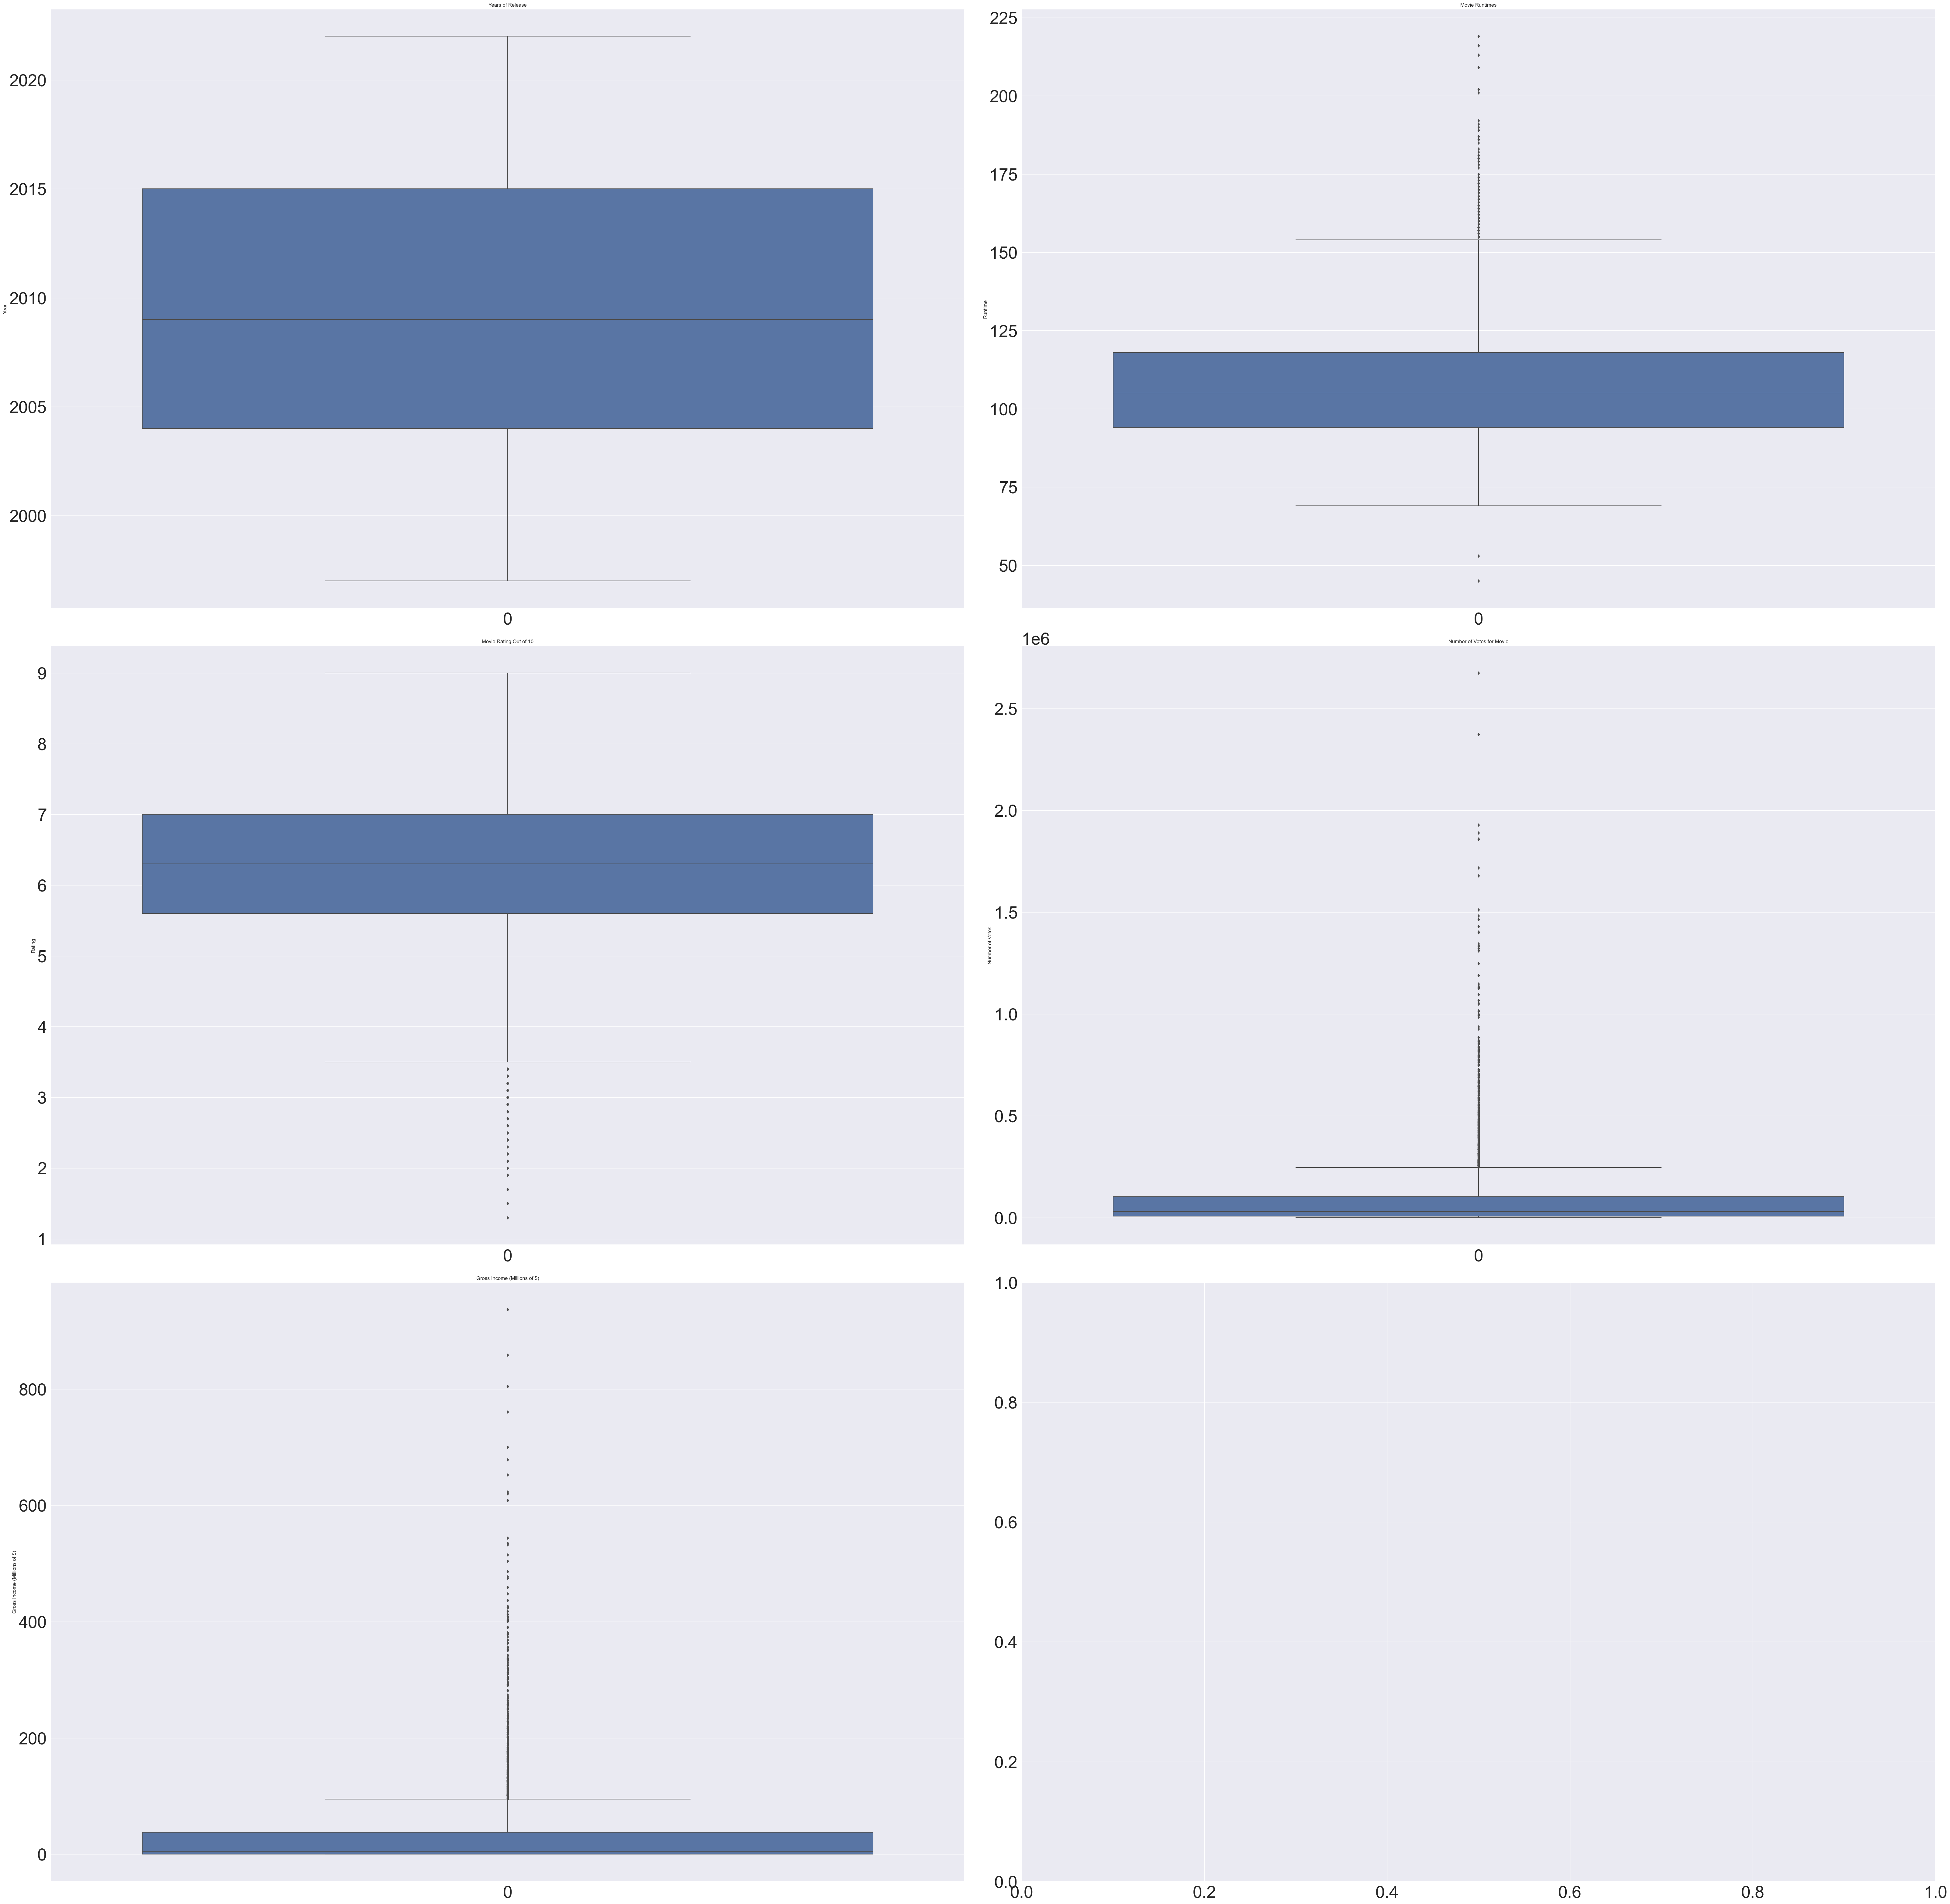

In [59]:
import seaborn as sns
plt.figure(figsize=(60,40))
plt.rc('font', size=40)          # controls default text sizes    # fontsize of the x and y labels
plt.rc('xtick', labelsize=40)    # fontsize of the tick labels
plt.rc('ytick', labelsize=40) 
fig, (ax1, ax2, ax3) = plt.subplots(3, 2, gridspec_kw={'wspace':1/16, 'hspace':1/16}, figsize=(80, 80))

sns.boxplot(df['year'],ax=ax1[0])
ax1[0].set_title('Years of Release')
ax1[0].set_ylabel('Year')

sns.boxplot(df['runtime'],ax=ax1[1])
ax1[1].set_title('Movie Runtimes')
ax1[1].set_ylabel('Runtime')

sns.boxplot(df['rating'],ax=ax2[0])
ax2[0].set_title('Movie Rating Out of 10')
ax2[0].set_ylabel('Rating')

sns.boxplot(df['votes'],ax=ax2[1])
ax2[1].set_title('Number of Votes for Movie')
ax2[1].set_ylabel('Number of Votes')

sns.boxplot(df['gross(in $)'],ax=ax3[0])
ax3[0].set_title('Gross Income (Millions of $)')
ax3[0].set_ylabel('Gross Income (Millions of $)')

In [60]:
def outliers(ls):
    q3= ls.quantile(0.75)
    q1= ls.quantile(0.25)
    IQR=q3-q1
    outliers_upper = ls.loc[ls > q3 + 1.5 * IQR]
    outliers_lower = df['runtime'].loc[df['runtime'] < q1 - 1.5 * IQR]
    num_outliers_runtime = len(outliers_lower)+len(outliers_upper)
    return num_outliers_runtime
    


In [61]:

print("Number of outliers detected in year data: " + str(outliers(df['year'])))
print("Number of outliers detected in runtime data: " + str(outliers(df['runtime'])))
print("Number of outliers detected in rating data: " + str(outliers(df['rating'])))
print("Number of outliers detected in votes data: " + str(outliers(df['votes'])))
print("Number of outliers detected in gross income data: " + str(outliers(df['gross(in $)'])))


Number of outliers detected in year data: 5038
Number of outliers detected in runtime data: 151
Number of outliers detected in rating data: 0
Number of outliers detected in votes data: 538
Number of outliers detected in gross income data: 515


<AxesSubplot: >

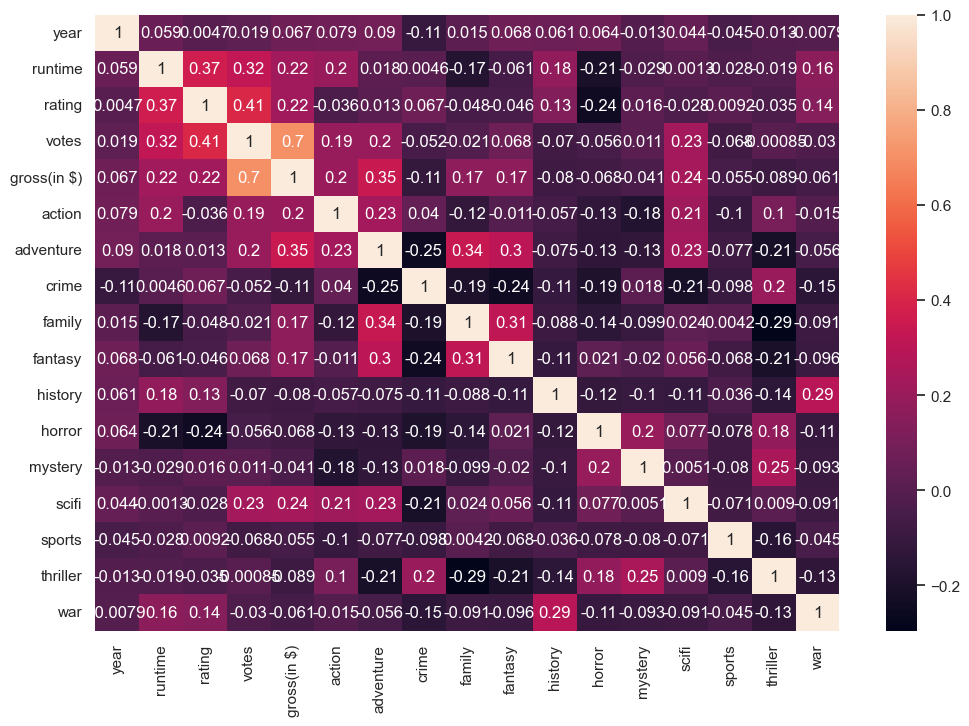

In [62]:
import seaborn as sns
# Correlation Matrix, dropping Film-Noir since none are in our dataframe anymore from the last 25 years
sns.set(rc={'figure.figsize':(12, 8)})
sns.heatmap(df.corr(), annot=True)


<font size="8">Using 'Year' as Numerical</font>


In [63]:
features = list(df.columns)
X_train, X_test, y_train, y_test = train_test_split(df[[f for f in features if f not in ['gross(in $)']]]
                                                    , df['gross(in $)'], test_size=0.2, random_state=42)

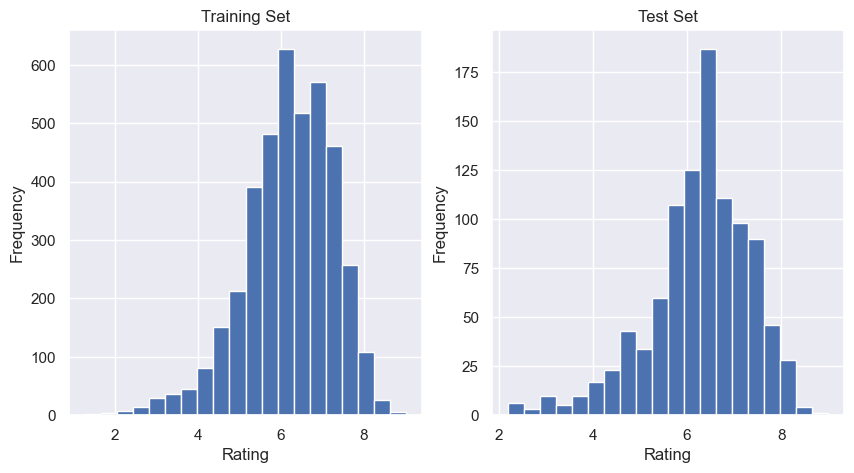

In [64]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].hist(X_train['rating'], bins=20)
ax[0].set_title('Training Set')
ax[0].set_xlabel('Rating')
ax[0].set_ylabel('Frequency')
ax[1].hist(X_test['rating'], bins=20)
ax[1].set_title('Test Set')
ax[1].set_xlabel('Rating')
ax[1].set_ylabel('Frequency')
plt.show()

In [65]:
num_scaler = StandardScaler()
ohe_encoder = OneHotEncoder()

In [66]:
X_train_num = X_train[[f for f in features if f not in ['gross(in $)', 'certificate']]]
X_train_cat = X_train[['certificate']]

X_train_num_scaled = num_scaler.fit_transform(X_train_num)
X_train_cat_encoded = ohe_encoder.fit_transform(X_train_cat)

In [67]:
X_train_preprocessed = pd.concat([
    pd.DataFrame(X_train_num_scaled, columns=[f for f in features if f not in ['gross(in $)', 'certificate']]),
    pd.DataFrame(X_train_cat_encoded.toarray(), columns=ohe_encoder.get_feature_names_out(['certificate']))
], axis=1)

In [68]:
X_test_num = X_test[[f for f in features if f not in ['gross(in $)', 'certificate']]]
X_test_cat = X_test[['certificate']]

X_test_num_scaled = num_scaler.transform(X_test_num)
X_test_cat_encoded = ohe_encoder.transform(X_test_cat)

In [69]:
X_test_preprocessed = pd.concat([
    pd.DataFrame(X_test_num_scaled, columns=[f for f in features if f not in ['gross(in $)', 'certificate']]),
    pd.DataFrame(X_test_cat_encoded.toarray(), columns=ohe_encoder.get_feature_names_out(['certificate']))
], axis=1)

<font size="5">Linear Regression</font>

In [70]:
model = LinearRegression()
model.fit(X_train_preprocessed, y_train)
y_pred = model.predict(pd.concat([pd.DataFrame(X_test_num_scaled, columns=[f for f in features if f not in ['gross(in $)', 'certificate']]), 
                                  pd.DataFrame(X_test_cat_encoded.toarray(), columns=ohe_encoder.get_feature_names_out(['certificate']))], axis=1))

print('R2 score:', r2_score(y_test, y_pred))
print('Mean squared error:', mean_squared_error(y_test, y_pred))
print('Mean absolute error:', mean_absolute_error(y_test, y_pred))

R2 score: 0.5490725989448865
Mean squared error: 2550.6725760605877
Mean absolute error: 25.960201924702947


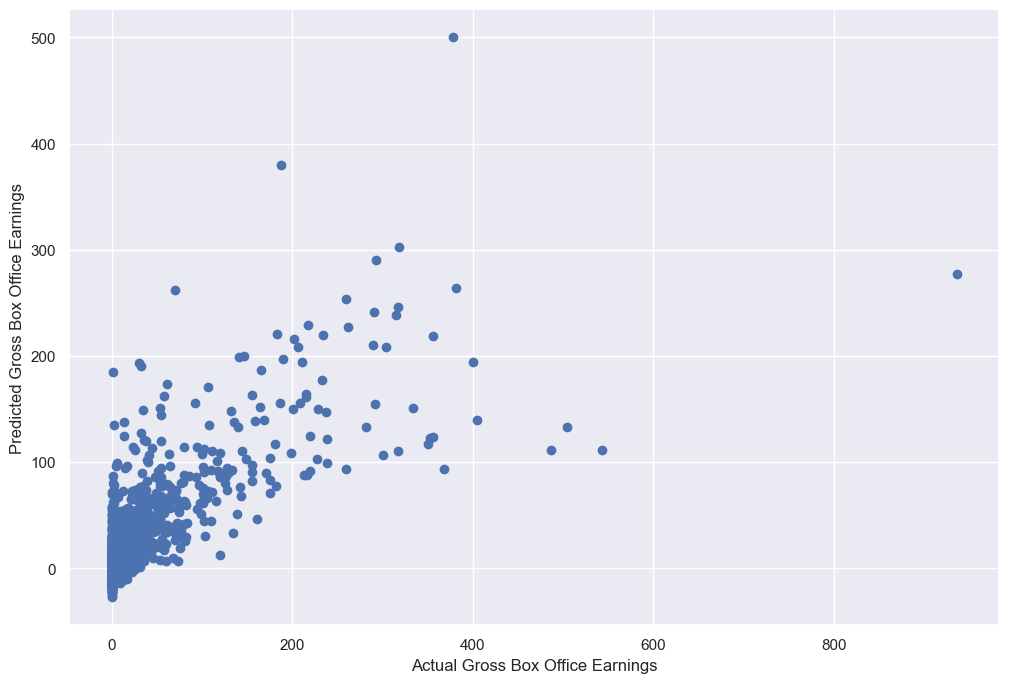

In [71]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Gross Box Office Earnings")
plt.ylabel("Predicted Gross Box Office Earnings")
plt.show()

<font size="5">Decision Tree</font>

In [72]:
model = DecisionTreeRegressor()
model.fit(X_train_preprocessed, y_train)
y_pred = model.predict(X_test_preprocessed)

print('R2 score:', r2_score(y_test, y_pred))
print('Mean squared error:', mean_squared_error(y_test, y_pred))
print('Mean absolute error:', mean_absolute_error(y_test, y_pred))

R2 score: 0.545150986998147
Mean squared error: 2572.8551891000584
Mean absolute error: 21.793811926587303


<font size="8">Using Year as Categorical (5-year increment)</font>

In [73]:
df['year_category'] = (((df['year'] - 1910) // 5) * 5 + 1910) // 10 * 10
df['year_category'] = df['year_category'].apply(lambda x: str(x) + '-' + str(x+4) if (x+3) < 2023 else str(x) + '-2022')
df

,year,certificate,runtime,rating,votes,gross(in $),action,adventure,crime,family,fantasy,history,horror,mystery,scifi,sports,thriller,war,year_category
0,2018,PG-13,134.0,7.3,785813.0,700.059566,1,1,0,0,0,0,0,0,1,0,0,0,2010-2014
1,2009,PG-13,162.0,7.9,1322694.0,760.507625,1,1,0,0,1,0,0,0,1,0,0,0,2000-2004
2,2012,PG-13,142.0,7.2,927499.0,408.010692,1,1,0,0,0,0,0,0,1,0,1,0,2010-2014
3,2021,PG-13,155.0,8.0,649342.0,108.327830,1,1,0,0,0,0,0,0,1,0,0,0,2020-2022
4,2001,PG-13,178.0,8.8,1889727.0,315.544750,1,1,0,0,1,0,0,0,0,0,0,0,2000-2004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11270,2012,R,102.0,7.1,5284.0,0.148408,0,0,0,0,0,0,0,0,0,0,0,1,2010-2014
11271,2000,PG-13,117.0,7.6,5242.0,1.320112,0,0,0,0,0,0,0,0,0,0,0,1,2000-2004
11273,1999,R,107.0,6.7,2543.0,0.261360,0,0,0,0,0,0,0,0,0,0,0,1,1990-1994
11277,2000,NR,117.0,6.2,1742.0,0.110281,0,0,0,0,0,0,0,0,0,0,0,1,2000-2004


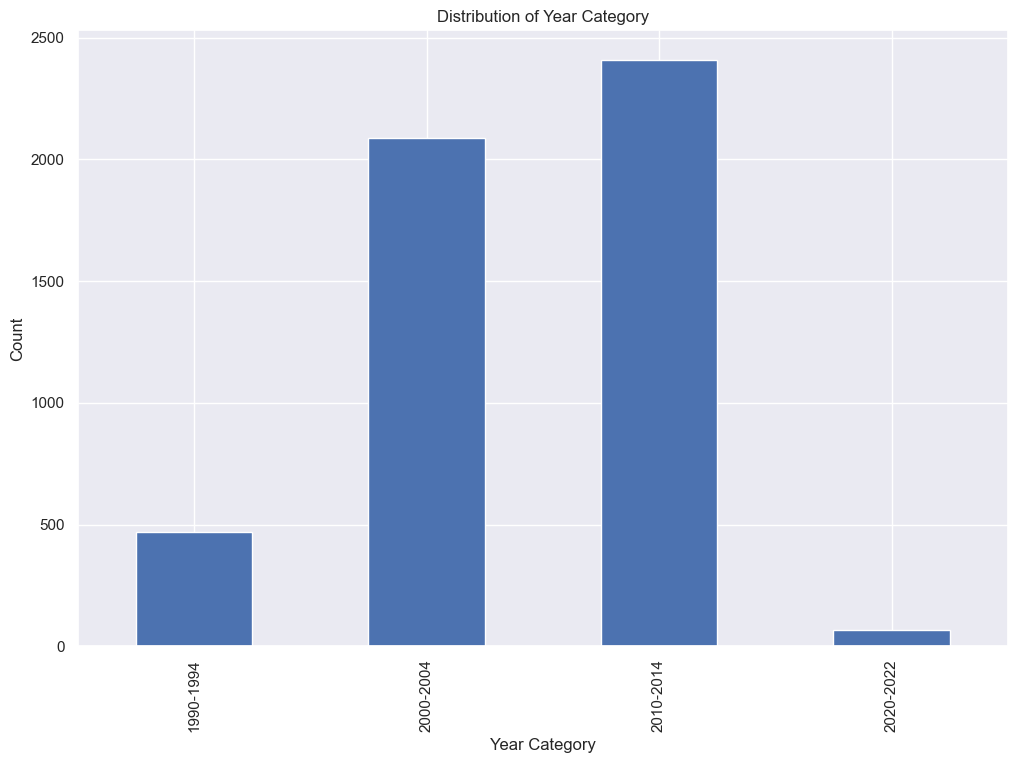

In [74]:
year_counts = df['year_category'].value_counts().sort_index()
year_counts.plot.bar()
plt.title('Distribution of Year Category')
plt.xlabel('Year Category')
plt.ylabel('Count')
plt.show()

In [75]:
features.append('year_category')
X_train, X_test, y_train, y_test = train_test_split(df[[f for f in features if f not in ['year', 'gross(in $)']]]
                                                    , df['gross(in $)'], test_size=0.2, random_state=42)

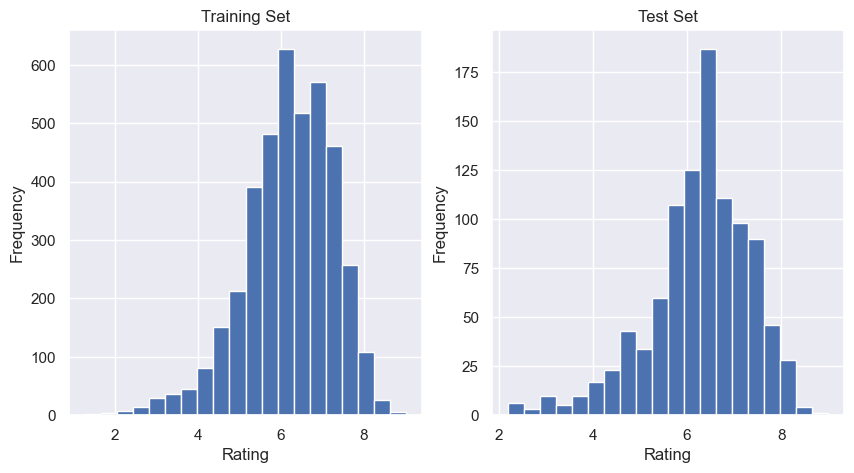

In [76]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].hist(X_train['rating'], bins=20)
ax[0].set_title('Training Set')
ax[0].set_xlabel('Rating')
ax[0].set_ylabel('Frequency')
ax[1].hist(X_test['rating'], bins=20)
ax[1].set_title('Test Set')
ax[1].set_xlabel('Rating')
ax[1].set_ylabel('Frequency')
plt.show()

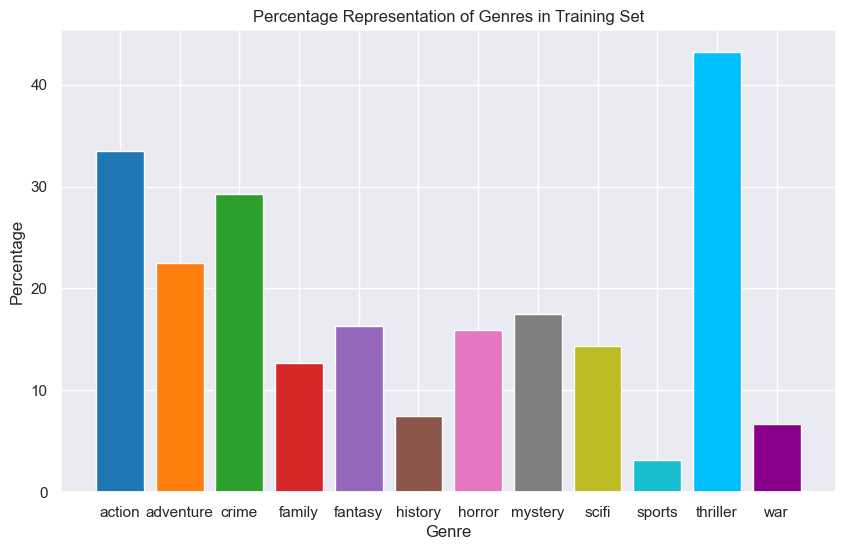

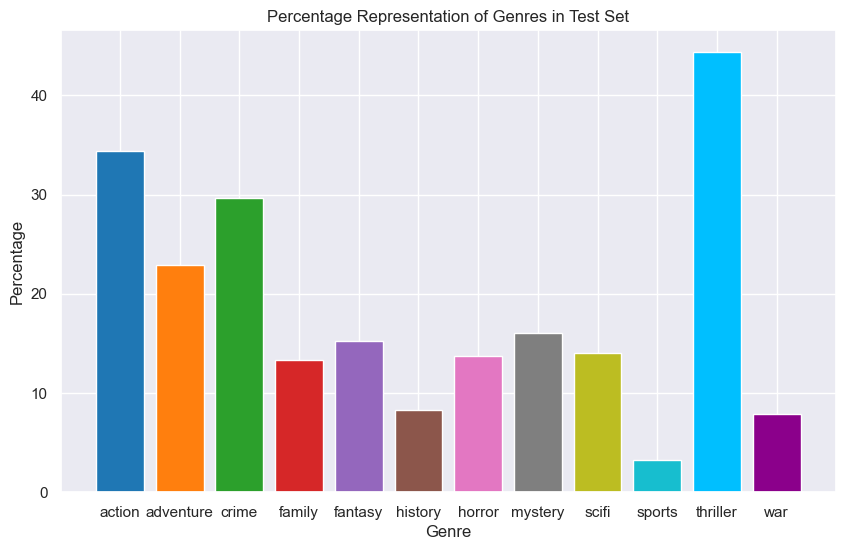

In [77]:
# Distribution of Genres
# Extract the genre columns from the train and test sets
genre_cols = ['action', 'adventure', 'crime', 'family', 'fantasy', 'history', 'horror', 'mystery', 'scifi', 'sports', 'thriller', 'war']
X_train_genre = X_train[genre_cols]
X_test_genre = X_test[genre_cols]

# Define colors for each genre
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b',
          '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#00bfff', '#8b008b', '#ff1493']

# Calculate percentage representation of each genre in the training set
train_genre_counts = X_train_genre.sum(axis=0)
train_genre_percents = train_genre_counts / len(X_train_genre) * 100

# Plot barplot for training set
fig, ax = plt.subplots(figsize=(10, 6))
plt.bar(train_genre_percents.index, train_genre_percents, color=colors)
plt.title('Percentage Representation of Genres in Training Set')
plt.xlabel('Genre')
plt.ylabel('Percentage')
plt.show()

# Calculate percentage representation of each genre in the test set
test_genre_counts = X_test_genre.sum(axis=0)
test_genre_percents = test_genre_counts / len(X_test_genre) * 100

# Plot barplot for test set
fig, ax = plt.subplots(figsize=(10, 6))
plt.bar(test_genre_percents.index, test_genre_percents, color=colors)
plt.title('Percentage Representation of Genres in Test Set')
plt.xlabel('Genre')
plt.ylabel('Percentage')
plt.show()


In [78]:
X_train_num = X_train[[f for f in features if f not in ['year', 'certificate', 'gross(in $)', 'year_category']]]
X_train_cat = X_train[['certificate', 'year_category']]

X_train_num_scaled = num_scaler.fit_transform(X_train_num)
X_train_cat_encoded = ohe_encoder.fit_transform(X_train_cat)


In [79]:
X_train_preprocessed = pd.concat([
    pd.DataFrame(X_train_num_scaled, columns=[f for f in features if f not in ['year', 'certificate', 'gross(in $)', 'year_category']]),
    pd.DataFrame(X_train_cat_encoded.toarray(), columns=ohe_encoder.get_feature_names_out(['certificate','year_category']))
], axis=1)

In [80]:
X_test_num = X_test[[f for f in features if f not in ['year', 'certificate', 'gross(in $)', 'year_category']]]
X_test_cat = X_test[['certificate', 'year_category',]]

X_test_num_scaled = num_scaler.transform(X_test_num)
X_test_cat_encoded = ohe_encoder.transform(X_test_cat)

In [81]:
X_test_preprocessed = pd.concat([
    pd.DataFrame(X_test_num_scaled, columns=[f for f in features if f not in ['year', 'certificate', 'gross(in $)', 'year_category']]),
    pd.DataFrame(X_test_cat_encoded.toarray(), columns=ohe_encoder.get_feature_names_out(['certificate', 'year_category']))
], axis=1)

<font size="5">Linear Regression</font>

In [82]:
model = LinearRegression()
model.fit(X_train_preprocessed, y_train)
y_pred = model.predict(pd.concat([pd.DataFrame(X_test_num_scaled, columns=[f for f in features if f not in ['year', 'certificate', 'gross(in $)', 'year_category']]), 
                                  pd.DataFrame(X_test_cat_encoded.toarray(), columns=ohe_encoder.get_feature_names_out(['certificate', 'year_category']))], axis=1))

print('R2 score:', r2_score(y_test, y_pred))
print('Mean squared error:', mean_squared_error(y_test, y_pred))
print('Mean absolute error:', mean_absolute_error(y_test, y_pred))

R2 score: 0.5466486157610958
Mean squared error: 2564.3838462501126
Mean absolute error: 25.888341562203976


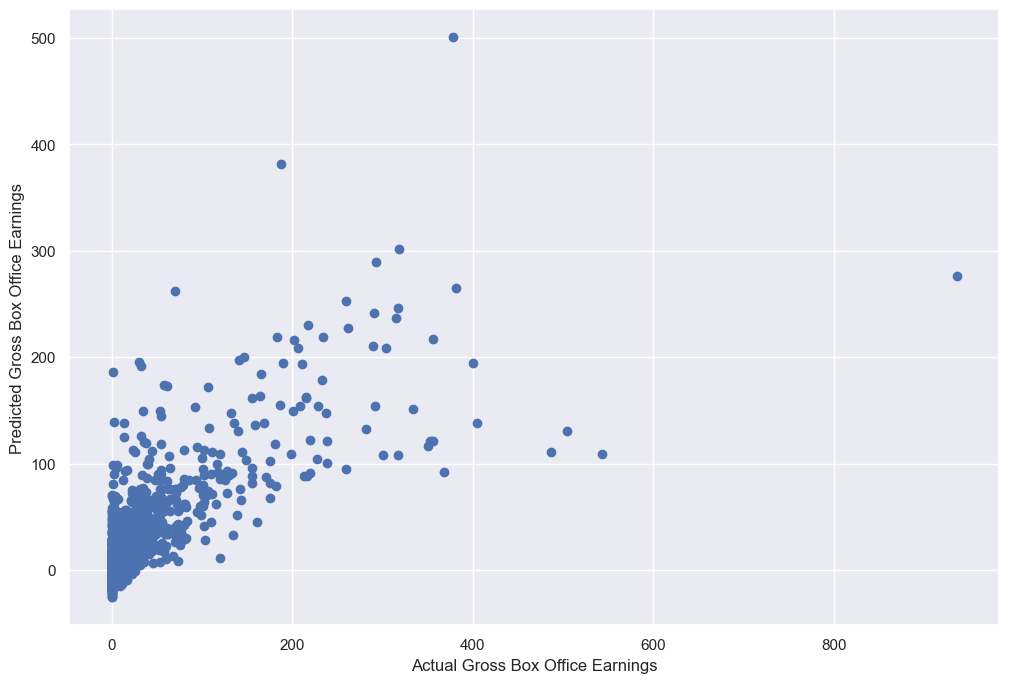

In [83]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Gross Box Office Earnings")
plt.ylabel("Predicted Gross Box Office Earnings")
plt.show()

<font size="5">Decision Tree</font>

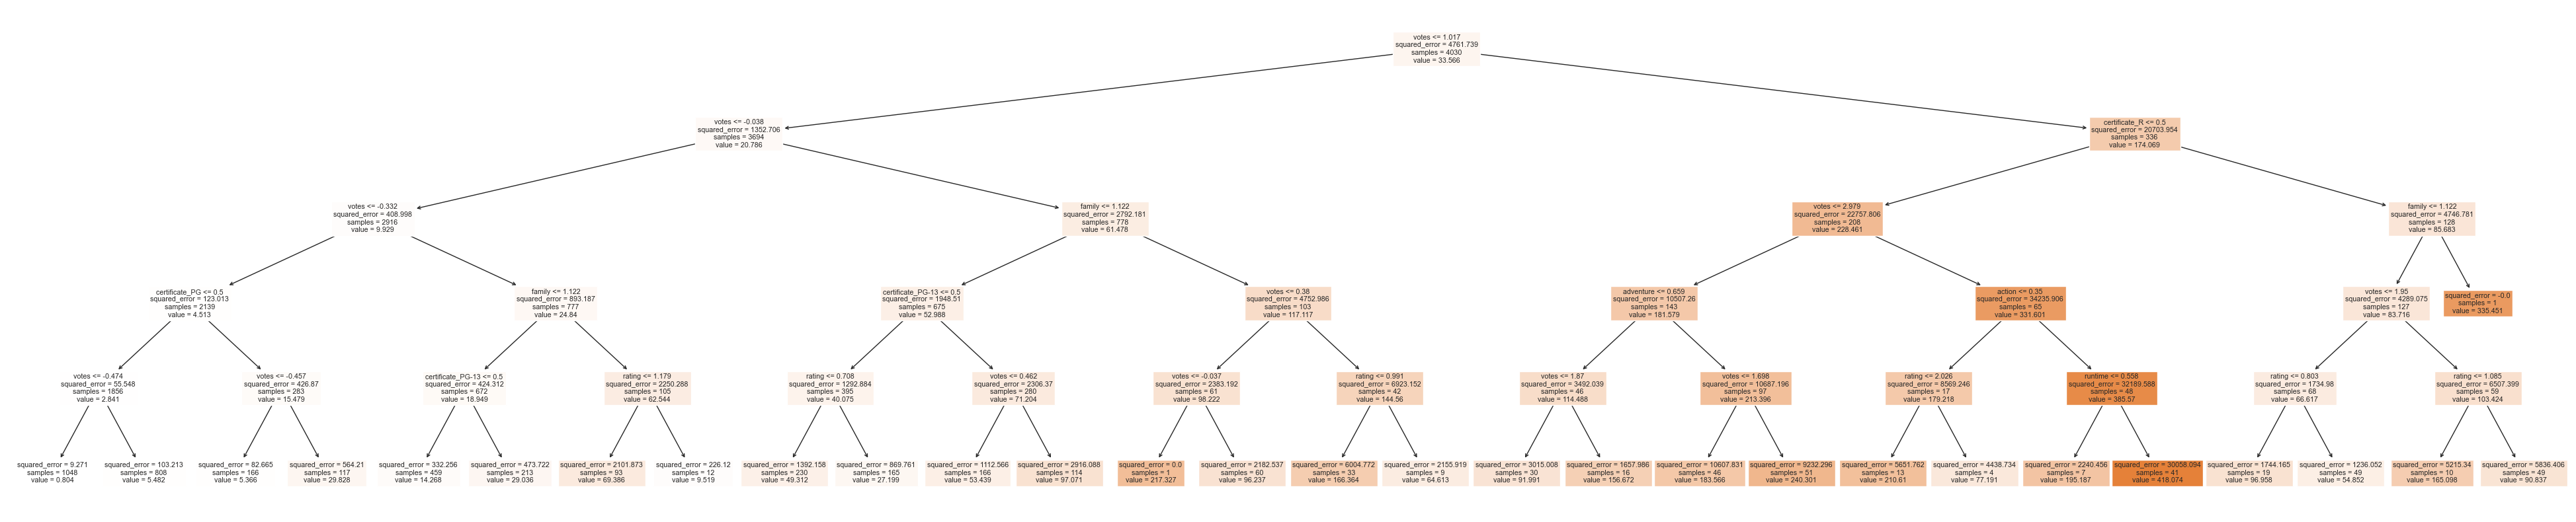

R2 score: 0.6515467046279526
Mean squared error: 1971.0274036657856
Mean absolute error: 20.203461479054976


In [84]:
model = DecisionTreeRegressor(max_depth=5)
model.fit(X_train_preprocessed, y_train)
y_pred= model.predict(pd.concat([pd.DataFrame(X_test_num_scaled, columns=[f for f in features if f not in ['year', 'certificate', 'gross(in $)', 'year_category']]),
                                  pd.DataFrame(X_test_cat_encoded.toarray(), columns=ohe_encoder.get_feature_names_out(['certificate', 'year_category']))], axis=1))

feature_names = X_train_preprocessed.columns
plt.figure(figsize=(50, 10))
plot_tree(model, filled=True, feature_names=feature_names)
plt.show()

print('R2 score:', r2_score(y_test, y_pred))
print('Mean squared error:', mean_squared_error(y_test, y_pred))
print('Mean absolute error:', mean_absolute_error(y_test, y_pred))

<font size="5">SVR</font>

In [85]:
model = SVR(kernel='rbf', C=100, gamma='auto')
model.fit(X_train_preprocessed, y_train)
y_pred = model.predict(pd.concat([pd.DataFrame(X_test_num_scaled, columns=[f for f in features if f not in ['year', 'certificate', 'gross(in $)', 'year_category']]), 
                                  pd.DataFrame(X_test_cat_encoded.toarray(), columns=ohe_encoder.get_feature_names_out(['certificate', 'year_category']))], axis=1))

print('R2 score:', r2_score(y_test, y_pred))
print('Mean squared error:', mean_squared_error(y_test, y_pred))
print('Mean absolute error:', mean_absolute_error(y_test, y_pred))

R2 score: 0.7012148154328599
Mean squared error: 1690.0795441247963
Mean absolute error: 17.5554141424175


<font size="5">Random Forest</font>

In [86]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train_preprocessed, y_train)

y_pred = rf.predict(pd.concat([pd.DataFrame(X_test_num_scaled, columns=[f for f in features if f not in ['year', 'certificate', 'gross(in $)', 'year_category']]), 
                                  pd.DataFrame(X_test_cat_encoded.toarray(), columns=ohe_encoder.get_feature_names_out(['certificate', 'year_category']))], axis=1))
mse = mean_squared_error(y_test, y_pred)
print('Mean squared error:', mse)

Mean squared error: 1643.5444553985403


<font size="5">XGBoost</font>

In [87]:
model = xgb.XGBRegressor()
model.fit(X_train_preprocessed, y_train)

y_pred = model.predict(X_test_preprocessed)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: ", rmse)

# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)

Root Mean Squared Error:  39.48000179060827


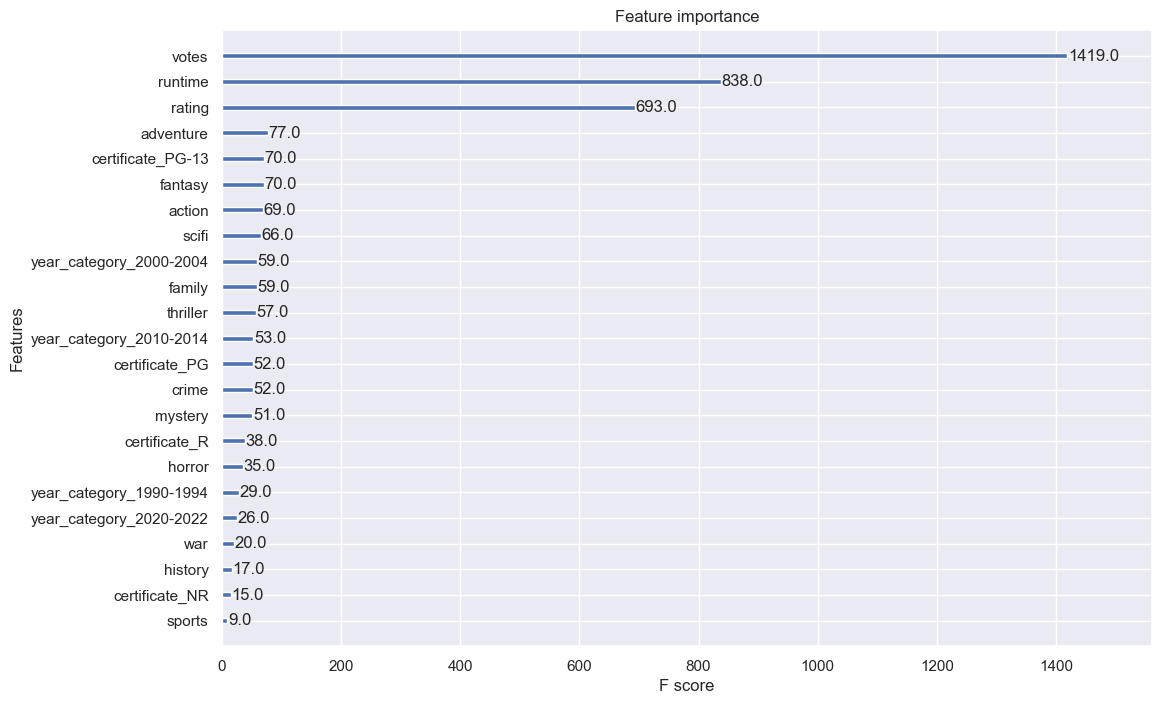

In [88]:
xgb.plot_importance(model)
plt.show()

<font size="5">Hyperparameter Optimization: Grid Search on Gradient Boosting</font>

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RepeatedKFold, GridSearchCV

gbr = GradientBoostingRegressor()
grid = dict()
grid['n_estimators'] = [10, 50, 100, 1000]
grid['learning_rate'] = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1]
grid['subsample'] = [0.5, 0.7, 1.0]
grid['max_depth'] = [3, 5, 7]

rskf = RepeatedKFold(n_repeats=3, n_splits=10, random_state=420210)
grid_search = GridSearchCV(estimator=gbr, param_grid=grid, cv=rskf)
# search over our floating values
grid_result = grid_search.fit(X=df[[f for f in features if f not in ['year', 'certificate', 'gross(in $)', 'year_category']]], y=df['gross(in $)'])

In [50]:
print('OPTIMAL: %f with params: %s' % (grid_result.best_score_, grid_result.best_params_))

test_means = grid_result.cv_results_['mean_test_score']
test_stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for test_mean, test_std, param in zip(test_means, test_stds, params):
    print("%f (%f) with params: %r" % (test_mean, test_std, param))

OPTIMAL: 0.699134 with params: {'learning_rate': 0.005, 'max_depth': 5, 'n_estimators': 1000, 'subsample': 0.5}
-0.000907 (0.002224) with params: {'learning_rate': 0.0001, 'max_depth': 3, 'n_estimators': 10, 'subsample': 0.5}
-0.000917 (0.002215) with params: {'learning_rate': 0.0001, 'max_depth': 3, 'n_estimators': 10, 'subsample': 0.7}
-0.000917 (0.002211) with params: {'learning_rate': 0.0001, 'max_depth': 3, 'n_estimators': 10, 'subsample': 1.0}
0.003981 (0.002083) with params: {'learning_rate': 0.0001, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.5}
0.003951 (0.002097) with params: {'learning_rate': 0.0001, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}
0.003938 (0.002064) with params: {'learning_rate': 0.0001, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
0.010064 (0.002085) with params: {'learning_rate': 0.0001, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.5}
0.010019 (0.002100) with params: {'learning_rate': 0.0001, 'max_depth': 3, 'n_estimators': 10